In [1]:
#import
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras import layers
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
!pip install split-folders

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Unzip & Load the dataset
!unzip -q '/content/drive/MyDrive/Utkranti/CSI Hackathon/Disaster detection/Cyclone_Wildfire_Flood_Earthquake_Database.zip'

In [5]:
import splitfolders

input_folder = '/content/Cyclone_Wildfire_Flood_Earthquake_Database'
output_folder = '/content/sample_data/Categorised'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .2))

Copying files: 4428 files [00:45, 98.19 files/s] 


In [6]:
DATASET_PATH = '/content/sample_data/Categorised'
train_path = '/content/sample_data/Categorised/train'
validate_path = '/content/sample_data/Categorised/val'

categories = ["Cyclone","Earthquake", "Flood", "Wildfire"]
n = len(categories)
im_size = 35
target_size = (im_size, im_size)
channels = 1

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array

train_data_gen = ImageDataGenerator(
    rotation_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5,1.5],
    channel_shift_range=0.05,
    rescale=1./255
)
test_data_gen = ImageDataGenerator(
    rescale = 1./255
)

train_generator = train_data_gen.flow_from_directory(train_path, target_size=target_size, color_mode='grayscale', class_mode='categorical', classes=categories, seed=42)
test_generator = test_data_gen.flow_from_directory(validate_path, target_size=target_size, color_mode='grayscale', class_mode='categorical', classes=categories, seed=42)


Found 3541 images belonging to 4 classes.
Found 887 images belonging to 4 classes.


In [8]:
import math, random

def get_subplot_grid(mylist, columns, figwidth, figheight):
  plot_rows = math.ceil(len(mylist)/2.)
  fig, ax = plt.subplots(plot_rows, 2, sharex=False, sharey=True)
  fig.set_figwidth(figwidth)
  fig.set_figheight(figheight)
  fig.subplots_adjust(hspace=0.4)
  axflat=ax.flat
  for ax in axflat[ax.size - 1: len(mylist) - 1: -1]:
    ax.set_visible(False)
  return fig, axflat

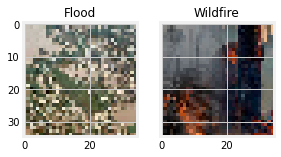

<Figure size 432x288 with 0 Axes>

In [9]:
import os

from keras_preprocessing.image import img_to_array, load_img
test_images_classes = ["Flood","Wildfire"]
test_images = []

fig, axflat = get_subplot_grid(mylist=test_images_classes, columns=2, figwidth=4, figheight=6)
for idx, label in enumerate(test_images_classes):
    image_folder = os.path.join(train_path, label)
    image_file = os.path.join(image_folder, random.choice(os.listdir(image_folder)) )
    loaded_image =load_img(path=image_file,target_size=(im_size, im_size ,1))
    #convert to array and resample dividing by 255
    img_array = img_to_array(loaded_image) / 255.
    test_images.append({"idx":idx, "image":img_array, "label": label})
    
    axflat[idx].set_title(label, size=12)
    axflat[idx].imshow(img_array)
plt.show()
plt.gcf().clear()

In [10]:
from pprint import pprint

trained_classes_labels = list(train_generator.class_indices.keys())
pprint(train_generator.class_indices)

{'Cyclone': 0, 'Earthquake': 1, 'Flood': 2, 'Wildfire': 3}


In [11]:
unique, counts = np.unique(train_generator.classes, return_counts=True)
print("Number of samples per class: ")
pprint(dict(zip(train_generator.class_indices, counts)))

Number of samples per class: 
{'Cyclone': 742, 'Earthquake': 1080, 'Flood': 858, 'Wildfire': 861}


Training the Model

In [12]:
from keras.layers import MaxPooling2D, BatchNormalization, Activation, SpatialDropout2D, LeakyReLU, Dropout
def create_model():
  model = Sequential()
  model.add(Conv2D(filters=64, kernel_size=(3,3), padding = 'same', strides=(1, 1),
                                    input_shape = (im_size, im_size, channels),
                                    #kernel_regularizer=k.regularizers.l2(0.0005),
                                    name='conv2d_1'))
  model.add(BatchNormalization())
  model.add(Activation('relu', name='activation_conv2d_1'))

  model.add(SpatialDropout2D(0.2))
  model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', name='conv2d_2'))
    #normalize the output of different activations
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.5, name='activation_conv2d_2'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Flatten())
    
    # output features onto a dense layer
    #model.add(k.layers.Dense(units = len(trained_classes_labels) * 20, name='dense_1' ) )
  model.add(Dense(units = 250, name='dense_1' ) )
  model.add(Activation('relu', name='activation_dense_1'))

    # randomly switch off 50% of the nodes per epoch step to avoid overfitting
  model.add(Dropout(0.5))

    # output layer with the number of units equal to the number of categories
  model.add(Dense(units = len(trained_classes_labels), name='dense_2'))
  model.add(Activation('softmax', name='activation_final'))

  return model


my_model = create_model()

In [13]:
from keras.optimizers import RMSprop
my_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=RMSprop(lr=1e-4))# ,decay=1e-6))

In [14]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from datetime import datetime as dt
start=dt.now()
history = my_model.fit_generator(
    train_generator,
    #epochs
    steps_per_epoch = train_generator.n// 32,
    epochs = 10,

    validation_data = test_generator,
    validation_steps = test_generator.n // 32, #Batch size = 32

    #Printing progress
    verbose = 1,
    callbacks = [
                 EarlyStopping(monitor='val_loss', patience=3),
                 ModelCheckpoint("fruits_checkpoints.h5", monitor='val_loss', save_best_only=True),
                 TensorBoard(log_dir="logs/{:%d_%b_%Y_%H:%M:%S}".format(dt.now()))

    ]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
110/110 [==============================] - 147s 1s/step - loss: 2.8651 - accuracy: 0.3908 - val_loss: 1.3773 - val_accuracy: 0.3785
Epoch 2/10
110/110 [==============================] - 114s 1s/step - loss: 1.1546 - accuracy: 0.5117 - val_loss: 1.4420 - val_accuracy: 0.3507
Epoch 3/10
110/110 [==============================] - 114s 1s/step - loss: 1.1190 - accuracy: 0.5578 - val_loss: 1.5652 - val_accuracy: 0.3345
Epoch 4/10
110/110 [==============================] - 115s 1s/step - loss: 1.0758 - accuracy: 0.5616 - val_loss: 0.9707 - val_accuracy: 0.5856
Epoch 5/10
110/110 [==============================] - 115s 1s/step - loss: 1.0502 - accuracy: 0.5780 - val_loss: 0.8490 - val_accuracy: 0.6782
Epoch 6/10
110/110 [==============================] - 114s 1s/step - loss: 1.0606 - accuracy: 0.5857 - val_loss: 0.7933 - val_accuracy: 0.7130
Epoch 7/10
110/110 [==============================] - 114s 1s/step - loss: 1.0512 - accuracy: 0.5959 - val_loss: 0.9745 - val_accuracy: 0.6007

In [15]:
my_model.save('/content/drive/MyDrive/Utkranti/CSI Hackathon/Disaster detection/models/model_4')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Utkranti/CSI Hackathon/Disaster detection/models/model_4/assets


In [16]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 35, 35, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 35, 35, 64)        256       
_________________________________________________________________
activation_conv2d_1 (Activat (None, 35, 35, 64)        0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 35, 35, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 35, 35, 128)       512       
_________________________________________________________________
activation_conv2d_2 (LeakyRe (None, 35, 35, 128)       0